In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import os
import sys
import glob
import pathlib
import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing

In [2]:
dfs = {}
symbols = []
future_list = glob.glob("D:/quant/data/futures/*")
future_list = sorted(future_list, key = lambda x: pathlib.Path(x).name[:-4].split(".")[-1])
for i in future_list:
    symbol = pathlib.Path(i).name[:-4]
    # if symbol == "AU0.shfe":
    df = pd.read_csv(i)
    if df.shape[0] > 100:
        dfs[symbol] = df
        symbols.append(symbol)
    # break

In [3]:
np.where(df.open.values == 0)

(array([], dtype=int64),)

In [106]:
def get_change(df, base="open"):
    base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
    base_change_rate = base_change / df.loc[:(df.shape[0]-2),base].values*100
    return np.hstack([[0], base_change_rate])


def get_raw_feature_df(df):
    # volume check
    volume_mean, volume_std = df["volume"].mean(), df["volume"].std()
    df = df[~((df["volume"] > (volume_mean+3*volume_std))
              | (df["volume"] < -(volume_mean+3*volume_std)))].reset_index(drop=True)
    
    close = df["close"].values
    datetime = df["datetime"]
    df = df.drop(["datetime","volume","high","low"], axis=1)
    df = (df-df.min())/(df.max()-df.min())
    df["datetime"] = datetime
    
    # close_change = get_change(df, base="close")
    # close_open_rate = (df["close"] - df["open"]) / df["open"] * 100
    # labels = []
    # for cc,co in zip(np.hstack([close_change[1:], [0]]),
    #                  np.hstack([close_open_rate[1:], [0]])):
    #     if cc > 0 and  co > 0:
    #         label = 1 #(cc+co)/2/100
    #     else:
    #         label = 0
    #     # if label == np.inf or label == -np.inf:
    #     #     print("error", cc,co)
    #     labels.append(label)
    
    # df["label"] = np.array(labels) 
    close_change = df.loc[1:,"close"].values - df.loc[:(df.shape[0]-2),"close"].values
    df["label"] = np.hstack([[0], close_change]) # np.hstack([df["close"].values[1:], [0]]) 
    error_index = np.where(df["label"].values == np.inf)
    print(error_index)
    df = df.drop(error_index[0], axis=0).reset_index(drop=True)
    df = df.dropna().reset_index(drop=True)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)
    return df

def get_feature_df(df):
    # volume check
    volume_change = df.loc[1:,"volume"].values - df.loc[:(df.shape[0]-2),"volume"].values
    volume_change_rate = volume_change / df.loc[:(df.shape[0]-2),"volume"].values * 100
    df["volume_change"] = np.hstack([[0], volume_change_rate])
    df = df[~((df["volume_change"] > 300) | (df["volume_change"] < -300))].reset_index(drop=True)

    def get_change(df, base="open"):
        base_change = df.loc[1:,base].values - df.loc[:(df.shape[0]-2),base].values
        base_change_rate = base_change / df.loc[:(df.shape[0]-2),base].values*100
        return np.hstack([[0], base_change_rate])

    for col in ["close","open","high","low"]:
        df[col+"_change"] = get_change(df, base=col)

    # open 相对前日 close
    open_close_change = df.loc[1:,"open"].values - df.loc[:(df.shape[0]-2),"close"].values
    open_close_change_rate = open_close_change / df.loc[:(df.shape[0]-2),"close"].values * 100
    df["open_close_change"] = np.hstack([[0], open_close_change_rate])

    # 当日：开盘 收盘 最高 最低 差值 波动, 以开盘价和收盘价为基准
    df["high_open_rate"] = (df["high"] - df["open"]) / df["open"] * 100
    df["low_open_rate"] = (df["low"] - df["open"]) / df["open"] * 100
    df["close_open_rate"] = (df["close"] - df["open"]) / df["open"] * 100
    df["high_close_rate"] = (df["high"] - df["close"]) / df["close"] * 100
    df["low_close_rate"] = (df["low"] - df["close"]) / df["close"] * 100
    
    datetime = df["datetime"]
    df = df.drop(["datetime","open","high","low","close","volume"], axis=1)
    df = (df-df.min())/(df.max()-df.min())
    df["datetime"] = datetime
    
    df["label"] = np.hstack([df["close_open_rate"].values[1:], [0]]) # df["close"] - df["open"].apply(lambda x:1 if x>0 else 0)
    df = df.drop(0, axis=0).reset_index(drop=True)
    df = df.drop([len(df)-1], axis=0).reset_index(drop=True)

    df = df.dropna().reset_index(drop=True)
    return df

def split_sequences(df, window=30, step=1, train=True):
    # min_max_scaler = preprocessing.MinMaxScaler()
    # if train:
    #     min_max_scaler.fit(df.drop(["label"], axis=1))
    #     features = min_max_scaler.transform(df.drop(["label"], axis=1))
    #     labels = min_max_scaler.transform(df["label"].values.reshape(1,-1))
    # else:
    #     features = min_max_scaler.transform(df.drop(["label"], axis=1))
    #     labels = min_max_scaler.transform(df["label"].values.reshape(1,-1))
        
    X,y = [],[]
    for i in range(0, df.shape[0]-window, step):
        X.append(df.drop("label",axis=1).iloc[i:window+i,:].values)
        y.append(df.loc[i+window-1,"label"])

    return np.array(X), np.array(y)
    

from functools import reduce
def vstack_array(arrays):
    return reduce(lambda x, y: np.vstack([x,y]), arrays)
def hstack_array(arrays):
    return reduce(lambda x, y: np.hstack([x,y]), arrays)

In [107]:
window = 30

In [108]:
train_X, train_Y, valid_X, valid_Y, test_X, test_Y = [],[],[],[],[],[]
# for i,df in enumerate(dfs.values()):
df = dfs["AU0.shfe"]
df = get_raw_feature_df(deepcopy(df)) # get_feature_df(deepcopy(df))
train_df = df[df["datetime"] < '2021-07-01'].reset_index(drop=True)
valid_df = df[(df["datetime"] > "2021-07-01") & (df["datetime"] < "2022-01-01")].reset_index(drop=True)
test_df = df[df["datetime"] > "2022-01-01"].reset_index(drop=True)

train_x, train_y = split_sequences(df=train_df.drop(["datetime"], axis=1), window=window, train=True)
valid_x, valid_y = split_sequences(df=valid_df.drop(["datetime"], axis=1), window=window)
test_x, test_y = split_sequences(df=test_df.drop(["datetime"], axis=1), window=window)

if len(train_y) > 0:
    train_X.append(train_x)
    train_Y.append(train_y)
if len(valid_y) > 0:
    valid_X.append(valid_x)
    valid_Y.append(valid_y)
if len(test_y) > 0:
    test_X.append(test_x)
    test_Y.append(test_y)
# break
    

if len(train_Y) > 1:
    train_data, valid_data, test_data = (
                (vstack_array(train_X), hstack_array(train_Y)),
                (vstack_array(valid_X), hstack_array(valid_Y)),
                (vstack_array(test_X), hstack_array(test_Y)),
            )
else:
    train_data, valid_data, test_data = (
                (np.array(train_X[0]), np.array(train_Y[0])),
                (np.array(valid_X[0]), np.array(valid_Y[0])),
                (np.array(test_X[0]), np.array(test_Y[0])),
            )
    
print(len(train_data[0]), len(valid_data[0]), len(test_data[0]), train_data[0].shape)

(array([], dtype=int64),)
2702 94 108 (2702, 30, 2)


In [109]:
np.where(df.label.values == np.inf)

(array([], dtype=int64),)

In [110]:
np.where(train_data[1] == np.inf)

(array([], dtype=int64),)

In [ ]:
sys.path.append("D:/quant")
from models import LSTM, ALSTM, TCN

model = LSTM(
    d_feat=train_data[0].shape[2],
    hidden_size=4,
    batch_size=64,
    loss='mse',
    lr=0.001,
    early_stop=3,
    log_level="info",
)
history = model.fit(train_data,
        valid_data,
        save_path="D:/quant/checkpoint/model.pt")

preds = model.predict(test_data[0])
print(preds.shape)


In [112]:
# plt.plot(history["train"], label="train")
# plt.plot(history["valid"], label="train")
history

{'train': [-0.00017832309138265416,
  -0.0001786039713026964,
  -0.00017860537987178846,
  -0.00017659802722933126,
  -0.00018605395217448297,
  -0.00017797975291008092],
 'valid': [-0.00012963832705281675,
  -0.0001373212580801919,
  -0.00012379341933410615,
  -0.00012896818225272,
  -0.00012514684931375086,
  -0.00013190144090913236]}

100%|█████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 205.33it/s]


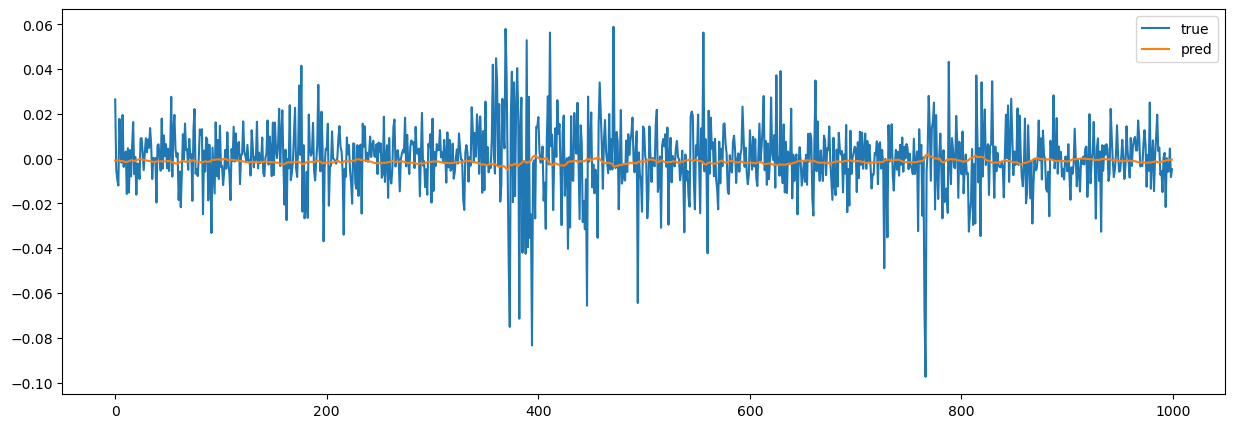

0.00023664557978815402


In [113]:
import matplotlib.pyplot as plt

def evaluate(data, label):
    fig = plt.figure(figsize = (15,5))
    plt.plot(label, label="true")
    preds = model.predict(data)
    plt.plot(preds, label="pred")
    plt.legend()
    plt.show()
    
    print(np.mean((preds - label)**2))

evaluate(train_data[0][:1000], train_data[1][:1000])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 182.34it/s]


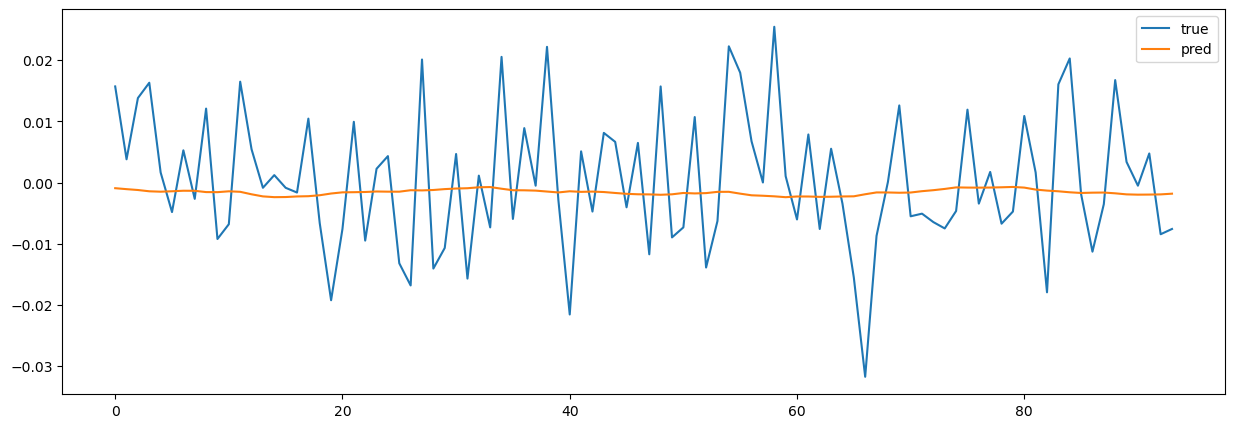

0.00012668172764348606


In [114]:
evaluate(valid_data[0][:1000], valid_data[1][:1000])

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 462.21it/s]


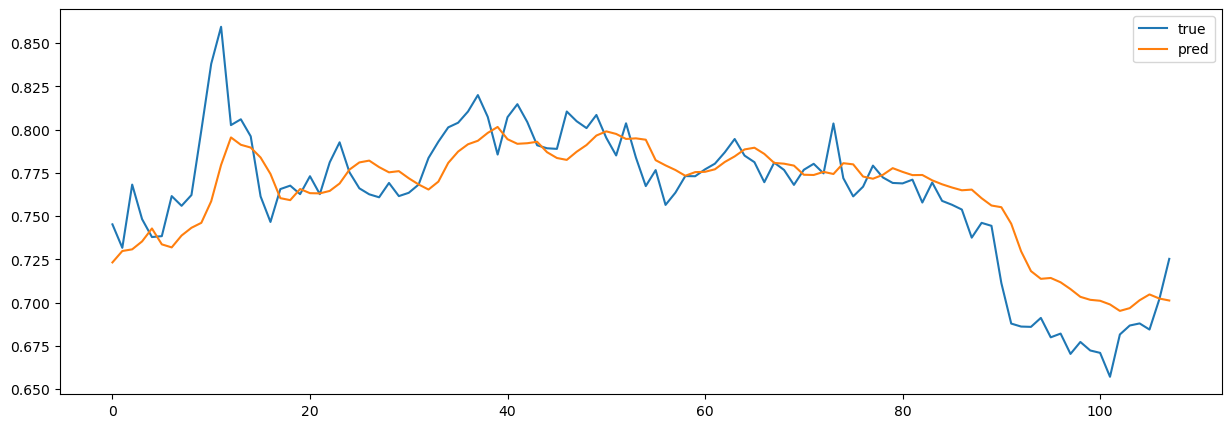

0.0004783817752642155


In [100]:
evaluate(test_data[0][:1000], test_data[1][:1000])

In [102]:
test_data[1][:10]

array([0.74521743, 0.73165781, 0.76819104, 0.74824027, 0.73787624,
       0.73839444, 0.76154079, 0.75592693, 0.76214536, 0.79954226])

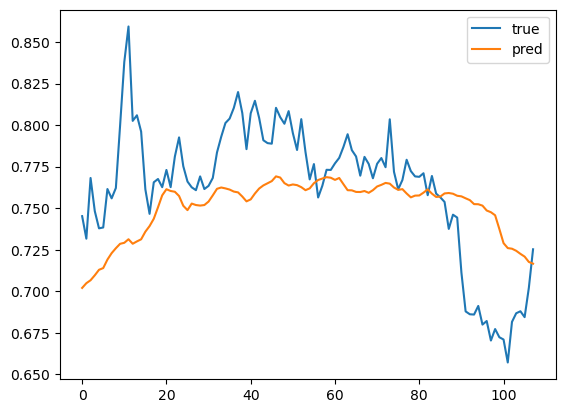

In [90]:
import numpy as np

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

import matplotlib.pyplot as plt

plt.plot(test_data[1], label="true")
plt.plot(preds, label="pred")
plt.legend()
plt.show()

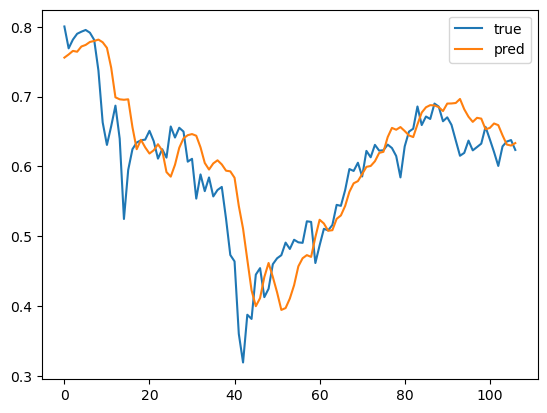

In [6]:
import numpy as np

def sigmoid(x):
    s = 1 / (1 + np.exp(-x))
    return s

import matplotlib.pyplot as plt

plt.plot(test_data[1], label="true")
plt.plot(preds, label="pred")
plt.legend()
plt.show()

In [21]:
loss = (preds - test_data[1]) ** 2
np.mean(loss)

0.7017188418002445

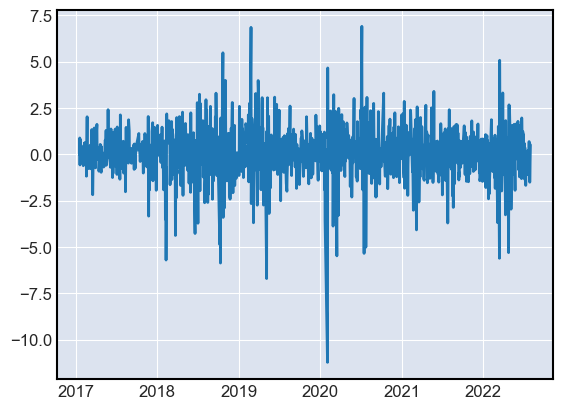

In [40]:
plt.plot(df_stockload["close_change"])

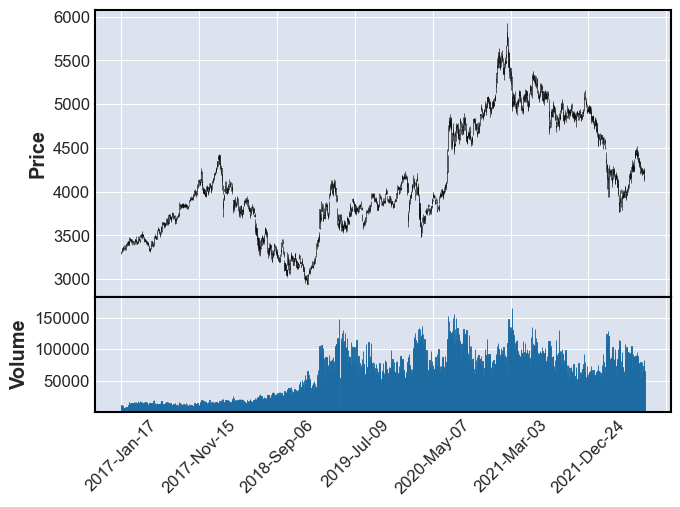

In [39]:
import mplfinance as mpf 

df_stockload = dfs["IF0.cffex"]
df_stockload.index = pd.to_datetime(df_stockload['datetime'])

mpf.plot(df_stockload,type='candle', volume=True)

In [126]:
a = np.array([])
b = np.expand_dims(a, axis=0)

In [127]:
len(a.shape)

1

In [128]:
a,b

(array([], dtype=float64), array([], shape=(1, 0), dtype=float64))